# Cross-subject encoding

Predicting each subject's activity using the synchronized activity of the other subjects. (Idk if any papers have done this, probably they have. Please someone lmk if they know of a reference.)

In [1]:
from pathlib import Path

SUBJECTS = [1, 2, 3, 5]

ROOT = Path("/ocean/projects/med220004p/clane2/algonauts25")
ALGONAUTS_2025_FMRI_ROOT = ROOT / "data/algonauts_2025_fmri"

OUT_DIR = ROOT / "experiments/cross_encoding/cross_encoding_v1"
OUT_DIR.mkdir(exist_ok=True, parents=True)

## Data loader

The data loader samples clips of synchronized activity from the same friends episodes across subjects. Each clip is shape `(n_subs, sample_length, dim)`.

In [2]:
import re
import time
from collections import defaultdict
from pathlib import Path

import h5py
import numpy as np
from torch.utils.data import IterableDataset
from tqdm import tqdm

In [3]:
class Algonauts2025FriendsFmri(IterableDataset):
    def __init__(
        self,
        root: str | Path,
        subjects: list[int] | None = None,
        seasons: list[int] | None = None,
        sample_length: int | None = 128,
        num_samples: int | None = None,
        shuffle: bool = True,
        keep_in_memory: bool = False,
        seed: int | None = None,
    ):
        self.root = root
        self.subjects = subjects or SUBJECTS
        self.seasons = seasons or list(range(1, 7))
        self.sample_length = sample_length
        self.num_samples = num_samples
        self.shuffle = shuffle
        self.keep_in_memory = keep_in_memory
        self.seed = seed

        self._files = {
            sub: h5py.File(
                Path(root)
                / f"data/sub-{sub:02d}/func"
                / f"sub-{sub:02d}_task-friends_space-MNI152NLin2009cAsym_atlas-Schaefer18_parcel-1000Par7Net_desc-s123456_bold.h5"
            )
            for sub in self.subjects
        }

        self._task_key_maps = defaultdict(dict)
        seasons_set = set(self.seasons)
        for sub, file in self._files.items():
            for key in file.keys():
                task = key.split("-")[-1]  # 'ses-066_task-s06e24d'
                season, _, _ = _parse_friends_task(task)
                if season in seasons_set:
                    self._task_key_maps[task][sub] = key

        self._task_list = sorted(
            [
                task for task, map in self._task_key_maps.items()
                if len(map) == len(self.subjects)
            ]
        )

        if self.keep_in_memory:
            self._data = defaultdict(dict)
            for sub in self.subjects:
                for task in self._task_list:
                    key = self._task_key_maps[task][sub]
                    self._data[sub][key] = self._files[sub][key][:]
        else:
            self._data = None

        self._rng = np.random.default_rng(seed)

    def _iter_shuffle(self):
        sample_idx = 0
        while True:
            task_order = self._rng.permutation(len(self._task_list))

            for ii in task_order:
                task = self._task_list[ii]

                keys = [self._task_key_maps[task][sub] for sub in self.subjects]
                datas = [self._get_data(sub, key) for sub, key in zip(self.subjects, keys)]
                length = min(len(data) for data in datas)

                if self.sample_length:
                    # Random segment of run
                    offset = int(self._rng.integers(0, length - self.sample_length + 1))
                    sample = np.stack(
                        [data[offset: offset + self.sample_length] for data in datas]
                    )
                else:
                    # Take full run
                    # Nb this only works for batch size 1 since runs are different length
                    sample = np.stack([data[:length] for data in datas])

                # todo: might also want to return task keys
                yield task, sample

                sample_idx += 1
                if self.num_samples and sample_idx >= self.num_samples:
                    return

    def _iter_ordered(self):
        sample_idx = 0
        for task in self._task_list:
            keys = [self._task_key_maps[task][sub] for sub in self.subjects]
            datas = [self._get_data(sub, key) for sub, key in zip(self.subjects, keys)]
            
            length = min(len(data) for data in datas)
            sample_length = self.sample_length or length

            for offset in range(0, length - sample_length + 1, sample_length):
                sample = np.stack([data[offset: offset + sample_length] for data in datas])
                yield task, sample

                sample_idx += 1
                if self.num_samples and sample_idx >= self.num_samples:
                    return

    def _get_data(self, sub: int, key: str):
        maps = self._data if self.keep_in_memory else self._files
        return maps[sub][key]

    def __iter__(self):
        if self.shuffle:
            yield from self._iter_shuffle()
        else:
            yield from self._iter_ordered()


def _parse_friends_task(task: str):
    match = re.match(r"s([0-9]+)e([0-9]+)([a-z])", task)
    season = int(match.group(1))
    episode = int(match.group(2))
    part = match.group(3)
    return season, episode, part

In [4]:
dataset = Algonauts2025FriendsFmri(
    root=ALGONAUTS_2025_FMRI_ROOT,
    seasons=range(1, 7),
    sample_length=64,
    num_samples=None,
    shuffle=False,
    keep_in_memory=True,
    seed=42,
)

total_bytes = 0
tic = time.monotonic()
for task, sample in tqdm(dataset):
    total_bytes += sample.size * 4
rt = time.monotonic() - tic
tput = total_bytes / 1024 ** 2 / rt 
print(f"run time={rt:.3f}s, MB/s={tput:.0f}")

1995it [00:00, 4856.64it/s]

run time=0.415s, MB/s=4696


## Model

Model architecture is a simple linear encoder and decoder for each subject. The encoder/decoder is "factorized" into a depthwise conv1d (to align data temporally), and a linear projection (to align data spatially).

For each subject, the input to the decoder is the average of the latents for the other three subjects.

In [5]:
from functools import partial

import torch
import torch.nn.functional as F
from torch import nn

In [6]:
class CausalConv1d(nn.Conv1d):
    """Conv1d layer with a causal mask, to only "attend" to past time points."""
    attn_mask: torch.Tensor

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: str | int = 0,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
    ):
        assert kernel_size % 2 == 1, "causal conv requires odd kernel size"
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )

        attn_mask = torch.zeros(kernel_size)
        attn_mask[:kernel_size // 2 + 1] = 1.0
        self.weight.data.mul_(attn_mask)
        self.register_buffer("attn_mask", attn_mask)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        weight = self.weight * self.attn_mask
        return F.conv1d(
            input, weight, self.bias, self.stride, self.padding, self.dilation, self.groups
        )

In [7]:
class ConvLinearEncoder(nn.Module):
    def __init__(
        self,
        in_features: int,
        embed_dim: int,
        kernel_size: int = 11,
        causal: bool = False,
    ):
        super().__init__()
        conv_layer = CausalConv1d if causal else nn.Conv1d
        self.conv = conv_layer(
            in_features,
            in_features,
            kernel_size=kernel_size,
            padding="same",
            groups=in_features,
        )
        self.fc = nn.Linear(in_features, embed_dim)

    def forward(self, x: torch.Tensor):
        # x: (N, L, C)
        x = x.transpose(-1, -2)
        x = self.conv(x)
        x = x.transpose(-1, -2)
        x = self.fc(x)
        return x


class ConvLinearDecoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        out_features: int,
        kernel_size: int = 11,
        causal: bool = False,
    ):
        super().__init__()
        conv_layer = CausalConv1d if causal else nn.Conv1d
        self.fc = nn.Linear(embed_dim, out_features)
        self.conv = conv_layer(
            out_features,
            out_features,
            kernel_size=kernel_size,
            padding="same",
            groups=out_features,
        )

    def forward(self, x: torch.Tensor):
        # x: (N, L, C)
        x = self.fc(x)
        x = x.transpose(-1, -2)
        x = self.conv(x)
        x = x.transpose(-1, -2)
        return x

In [8]:
encoder = ConvLinearEncoder(
    in_features=1000,
    embed_dim=256,
    causal=True
)
print(encoder)

# (N, L, C)
x = torch.randn(16, 64, 1000)
embed = encoder.forward(x)
print(embed.shape)

ConvLinearEncoder(
  (conv): CausalConv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
  (fc): Linear(in_features=1000, out_features=256, bias=True)
)
torch.Size([16, 64, 256])


In [9]:
class CrossSubjectConvLinearEncoder(nn.Module):
    weight: torch.Tensor

    def __init__(
        self,
        num_subjects: int,
        encoder_fn: type[nn.Module],
        decoder_fn: type[nn.Module],
        embed_dim: int = 256,
        normalize: bool = False,
    ):
        super().__init__()
        self.num_subjects = num_subjects
        # todo: could also consider having a shared group encoder/decoder
        self.encoders = nn.ModuleList([encoder_fn() for _ in range(num_subjects)])
        self.norm = nn.LayerNorm(embed_dim) if normalize else nn.Identity()
        self.decoders = nn.ModuleList([decoder_fn() for _ in range(num_subjects)])
        
        # todo: could learn the averaging weights
        weight = (1.0 - torch.eye(self.num_subjects)) / (self.num_subjects - 1.0)
        self.register_buffer("weight", weight)
        self.apply(init_weights)
    
    def forward(self, input: torch.Tensor):
        # input: (N, S, L, C)
        # subject specific encoders
        embed = torch.stack(
            [encoder(input[:, ii]) for ii, encoder in enumerate(self.encoders)],
            dim=1,
        )
        embed = self.norm(embed)
        # average pool the latents for all but target subject
        embed = torch.einsum("nslc,ts->ntlc", embed, self.weight)
        # subject specific decoders
        output = torch.stack(
            [decoder(embed[:, ii]) for ii, decoder in enumerate(self.decoders)],
            dim=1,
        )
        return output
    
    def forward_align(self, input: torch.Tensor):
        embed = torch.stack(
            [encoder(input[:, ii]) for ii, encoder in enumerate(self.encoders)],
            dim=1,
        )
        embed = self.norm(embed)
        decoder: ConvLinearDecoder = self.decoders[0]
        output = torch.stack(
            [decoder.fc(embed[:, ii]) for ii in range(embed.shape[1])],
            dim=1,
        )
        return output


def init_weights(m: nn.Module):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Linear)):
        nn.init.trunc_normal_(m.weight, std=0.02)
        nn.init.constant_(m.bias, 0)

In [10]:
encoder_fn = partial(ConvLinearEncoder, 1000, 256)
decoder_fn = partial(ConvLinearDecoder, 256, 1000)

cross_encoder = CrossSubjectConvLinearEncoder(
    num_subjects=4,
    encoder_fn=encoder_fn,
    decoder_fn=decoder_fn,
    embed_dim=256,
)
print(cross_encoder)

# (N, S, L, C)
x = torch.randn(16, 4, 64, 1000)
z = cross_encoder.forward(x)
print(z.shape)

CrossSubjectConvLinearEncoder(
  (encoders): ModuleList(
    (0-3): 4 x ConvLinearEncoder(
      (conv): Conv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
      (fc): Linear(in_features=1000, out_features=256, bias=True)
    )
  )
  (norm): Identity()
  (decoders): ModuleList(
    (0-3): 4 x ConvLinearDecoder(
      (fc): Linear(in_features=256, out_features=1000, bias=True)
      (conv): Conv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
    )
  )
)
torch.Size([16, 4, 64, 1000])


## Training

Basic training loop, AdamW, no lr decay, no bells and whistles.

In [11]:
import math

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from timm.utils import AverageMeter, random_seed

In [12]:
def train_one_epoch(
    *,
    epoch: int,
    model: torch.nn.Module,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    epoch_batches: int | None,
    device: torch.device,
):
    model.train()
    
    use_cuda = device.type == "cuda"
    if use_cuda:
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()

    loss_m = AverageMeter()
    data_time_m = AverageMeter()
    step_time_m = AverageMeter()

    epoch_batches = len(train_loader) if epoch_batches is None else epoch_batches
    first_step = epoch * epoch_batches

    end = time.monotonic()
    for batch_idx, (_, sample) in enumerate(train_loader):
        step = first_step + batch_idx
        sample = sample.to(device)
        batch_size = sample.size(0)
        data_time = time.monotonic() - end

        # forward pass
        output = model(sample)
        loss = F.mse_loss(output, sample)
        loss_item = loss.item()

        if math.isnan(loss_item) or math.isinf(loss_item):
            raise RuntimeError("NaN/Inf loss encountered on step %d; exiting", step)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # end of iteration timing
        if use_cuda:
            torch.cuda.synchronize()
        step_time = time.monotonic() - end

        loss_m.update(loss_item, batch_size)
        data_time_m.update(data_time, batch_size)
        step_time_m.update(step_time, batch_size)

        if step % 10 == 0:
            tput = batch_size / step_time_m.avg
            if use_cuda:
                alloc_mem_gb = torch.cuda.max_memory_allocated() / 1e9
                res_mem_gb = torch.cuda.max_memory_reserved() / 1e9
            else:
                alloc_mem_gb = res_mem_gb = 0.0

            print(
                f"Train: {epoch:>3d} [{batch_idx:>3d}/{epoch_batches}][{step:>6d}]"
                f"  Loss: {loss_m.val:#.3g} ({loss_m.avg:#.3g})"
                f"  Time: {data_time_m.avg:.3f},{step_time_m.avg:.3f} {tput:.0f}/s"
                f"  Mem: {alloc_mem_gb:.2f},{res_mem_gb:.2f} GB"
            )

        # Restart timer for next iteration
        end = time.monotonic()

In [13]:
@torch.no_grad()
def validate(
    *,
    epoch: int,
    model: torch.nn.Module,
    val_loader: DataLoader,
    device: torch.device,
):
    model.eval()

    use_cuda = device.type == "cuda"

    loss_m = AverageMeter()
    data_time_m = AverageMeter()
    step_time_m = AverageMeter()

    samples = []
    outputs = []

    end = time.monotonic()
    for batch_idx, (_, sample) in enumerate(val_loader):
        sample = sample.to(device)
        batch_size = sample.size(0)
        data_time = time.monotonic() - end

        # forward pass
        output = model(sample)
        loss = F.mse_loss(output, sample)
        loss_item = loss.item()

        # end of iteration timing
        if use_cuda:
            torch.cuda.synchronize()
        step_time = time.monotonic() - end

        loss_m.update(loss_item, batch_size)
        data_time_m.update(data_time, batch_size)
        step_time_m.update(step_time, batch_size)

        N, S, L, C = sample.shape
        assert N, S == (1, 4)
        samples.append(sample.cpu().numpy().swapaxes(0, 1).reshape((S, N*L, C)))
        outputs.append(output.cpu().numpy().swapaxes(0, 1).reshape((S, N*L, C)))

        # Reset timer
        end = time.monotonic()

    # (S, N, C)
    samples = np.concatenate(samples, axis=1)
    outputs = np.concatenate(outputs, axis=1)

    metrics = {}

    # Encoding accuracy metrics
    dim = samples.shape[-1]
    acc = 0.0
    acc_map = np.zeros(dim)
    for ii, sub in enumerate(SUBJECTS):
        y_true = samples[ii].reshape(-1, dim)
        y_pred = outputs[ii].reshape(-1, dim)
        metrics[f"acc_map_sub-{sub}"] = acc_map_i = pearsonr_score(y_true, y_pred)
        metrics[f"acc_sub-{sub}"] = acc_i = np.mean(acc_map_i)
        acc_map += acc_map_i / len(SUBJECTS)
        acc += acc_i / len(SUBJECTS)

    metrics["acc_map_avg"] = acc_map
    metrics["acc_avg"] = acc
    accs_fmt = ",".join(
        f"{val:.3f}" for key, val in metrics.items() if key.startswith("acc_sub-")
    )

    tput = batch_size / step_time_m.avg
    print(
        f"Val: {epoch:>3d}"
        f"  Loss: {loss_m.avg:#.3g}"
        f"  Acc: {accs_fmt} ({acc:.3f})"
        f"  Time: {data_time_m.avg:.3f},{step_time_m.avg:.3f} {tput:.0f}/s"
    )

    return acc, metrics


def pearsonr_score(
    y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-7
) -> np.ndarray:
    assert y_true.ndim == y_pred.ndim == 2

    y_true = y_true - y_true.mean(axis=0)
    y_true = y_true / (np.linalg.norm(y_true, axis=0) + eps)

    y_pred = y_pred - y_pred.mean(axis=0)
    y_pred = y_pred / (np.linalg.norm(y_pred, axis=0) + eps)

    score = (y_true * y_pred).sum(axis=0)
    return score

In [14]:
seed = 3315
batch_size = 16
sample_length = 64
n_train_samples = 2000
embed_dim = 256
kernel_size = 11
lr = 3e-4
weight_decay = 0.001
epochs = 10

In [15]:
random_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

Running on: cpu


In [16]:
train_dataset = Algonauts2025FriendsFmri(
    root=ALGONAUTS_2025_FMRI_ROOT,
    seasons=range(1, 6),
    sample_length=sample_length,
    num_samples=n_train_samples,
    shuffle=True,
    keep_in_memory=True,
    seed=42,
)

val_dataset = Algonauts2025FriendsFmri(
    root=ALGONAUTS_2025_FMRI_ROOT,
    seasons=[6],
    sample_length=None,
    shuffle=False,
    keep_in_memory=True,
)

In [17]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=1)

In [18]:
_, sample = next(iter(train_loader))
print("Sample shape:", tuple(sample.shape))

Sample shape: (16, 4, 64, 1000)


In [19]:
encoder_fn = partial(ConvLinearEncoder, 1000, embed_dim, kernel_size=kernel_size)
decoder_fn = partial(ConvLinearDecoder, embed_dim, 1000, kernel_size=kernel_size)

model = CrossSubjectConvLinearEncoder(
    num_subjects=4,
    encoder_fn=encoder_fn,
    decoder_fn=decoder_fn,
    embed_dim=embed_dim,
)
model = model.to(device)

param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Model:", model)
print(f"Num params: {param_count/1e6:.2f}M")

Model: CrossSubjectConvLinearEncoder(
  (encoders): ModuleList(
    (0-3): 4 x ConvLinearEncoder(
      (conv): Conv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
      (fc): Linear(in_features=1000, out_features=256, bias=True)
    )
  )
  (norm): Identity()
  (decoders): ModuleList(
    (0-3): 4 x ConvLinearDecoder(
      (fc): Linear(in_features=256, out_features=1000, bias=True)
      (conv): Conv1d(1000, 1000, kernel_size=(11,), stride=(1,), padding=same, groups=1000)
    )
  )
)
Num params: 2.15M


In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
epoch_batches = n_train_samples // batch_size

In [22]:
for epoch in range(epochs):
    train_one_epoch(
        epoch=epoch,
        model=model,
        train_loader=train_loader,
        optimizer=optimizer,
        epoch_batches=epoch_batches,
        device=device,
    )
    acc, metrics = validate(
        epoch=epoch,
        model=model,
        val_loader=val_loader,
        device=device,
    )

Train:   0 [  0/125][     0]  Loss: 0.379 (0.379)  Time: 0.009,2.909 5/s  Mem: 0.00,0.00 GB
Train:   0 [ 10/125][    10]  Loss: 0.380 (0.374)  Time: 0.005,0.392 41/s  Mem: 0.00,0.00 GB
Train:   0 [ 20/125][    20]  Loss: 0.387 (0.373)  Time: 0.005,0.272 59/s  Mem: 0.00,0.00 GB
Train:   0 [ 30/125][    30]  Loss: 0.373 (0.373)  Time: 0.005,0.239 67/s  Mem: 0.00,0.00 GB
Train:   0 [ 40/125][    40]  Loss: 0.383 (0.373)  Time: 0.005,0.221 73/s  Mem: 0.00,0.00 GB
Train:   0 [ 50/125][    50]  Loss: 0.355 (0.372)  Time: 0.005,0.207 77/s  Mem: 0.00,0.00 GB
Train:   0 [ 60/125][    60]  Loss: 0.352 (0.371)  Time: 0.005,0.198 81/s  Mem: 0.00,0.00 GB
Train:   0 [ 70/125][    70]  Loss: 0.349 (0.369)  Time: 0.005,0.191 84/s  Mem: 0.00,0.00 GB
Train:   0 [ 80/125][    80]  Loss: 0.344 (0.367)  Time: 0.005,0.185 86/s  Mem: 0.00,0.00 GB
Train:   0 [ 90/125][    90]  Loss: 0.345 (0.365)  Time: 0.005,0.185 87/s  Mem: 0.00,0.00 GB
Train:   0 [100/125][   100]  Loss: 0.348 (0.364)  Time: 0.005,0.181 88

In [82]:
with open(OUT_DIR / "ckpt.pt", "wb") as f:
    torch.save(
        {
            "model": model.state_dict(),
            "metrics": metrics,
            "acc": acc,
        },
        f,
    )

In [21]:
ckpt = torch.load(OUT_DIR / "ckpt.pt", map_location=device, weights_only=False)
metrics = ckpt["metrics"]
acc = ckpt["acc"]
model.load_state_dict(ckpt["model"])

<All keys matched successfully>

## Analysis

### Glass brain encoding accuracy

In [24]:
from nilearn import plotting
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nib
from matplotlib import pyplot as plt

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

In [88]:
atlas_path = ROOT / "resources/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz"
atlas = nib.load(atlas_path)

atlas_masker = NiftiLabelsMasker(atlas)
atlas_masker.fit()

NiftiLabelsMasker(labels_img=<nibabel.nifti1.Nifti1Image object at 0x7f01f84d73e0>,
                  memory=Memory(location=None))

In [89]:
def plot_encoding_accuracy(masker: NiftiLabelsMasker, acc_map: np.ndarray, sub: int, **kwargs):
    acc_vol = masker.inverse_transform(acc_map)
    acc = np.mean(acc_map)
    title = f"Cross encoding accuracy, sub-{sub:02d}, mean accuracy: {acc:.3f}"

    display = plotting.plot_glass_brain(
        acc_vol,
        display_mode="lyrz",
        cmap="hot_r",
        colorbar=True,
        plot_abs=False,
        symmetric_cbar=False,
        title=title,
        **kwargs,
    )
    colorbar = display._cbar
    colorbar.set_label("Pearson's $r$", rotation=90, labelpad=12, fontsize=12)

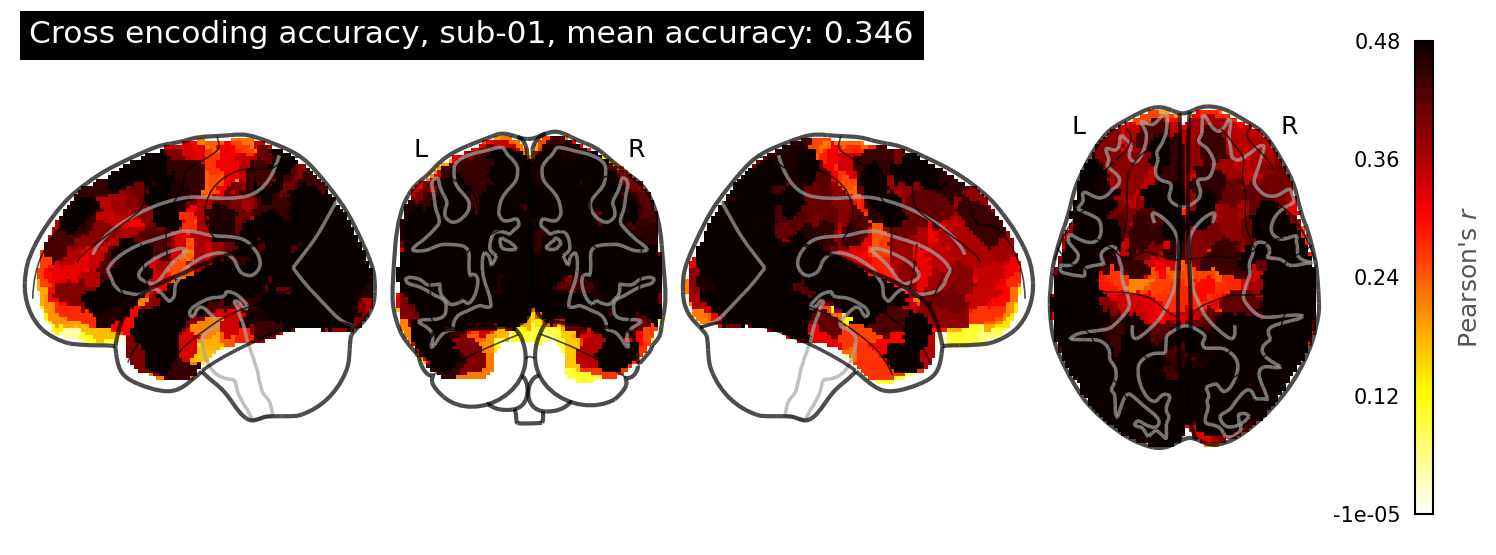

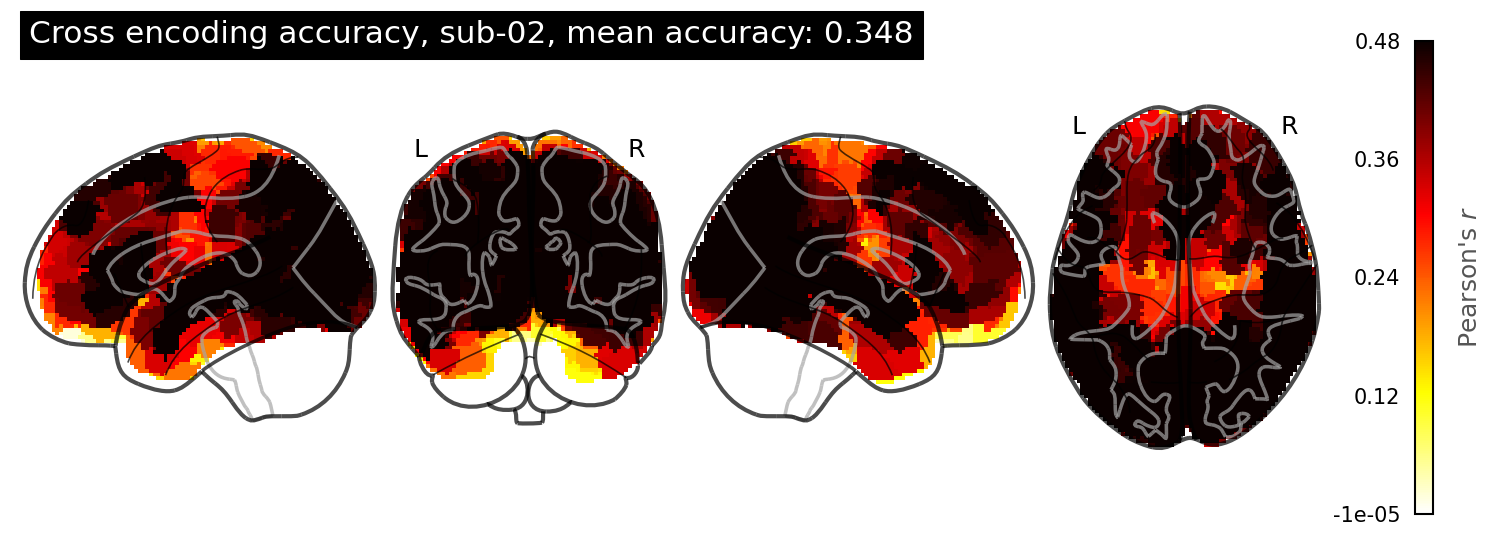

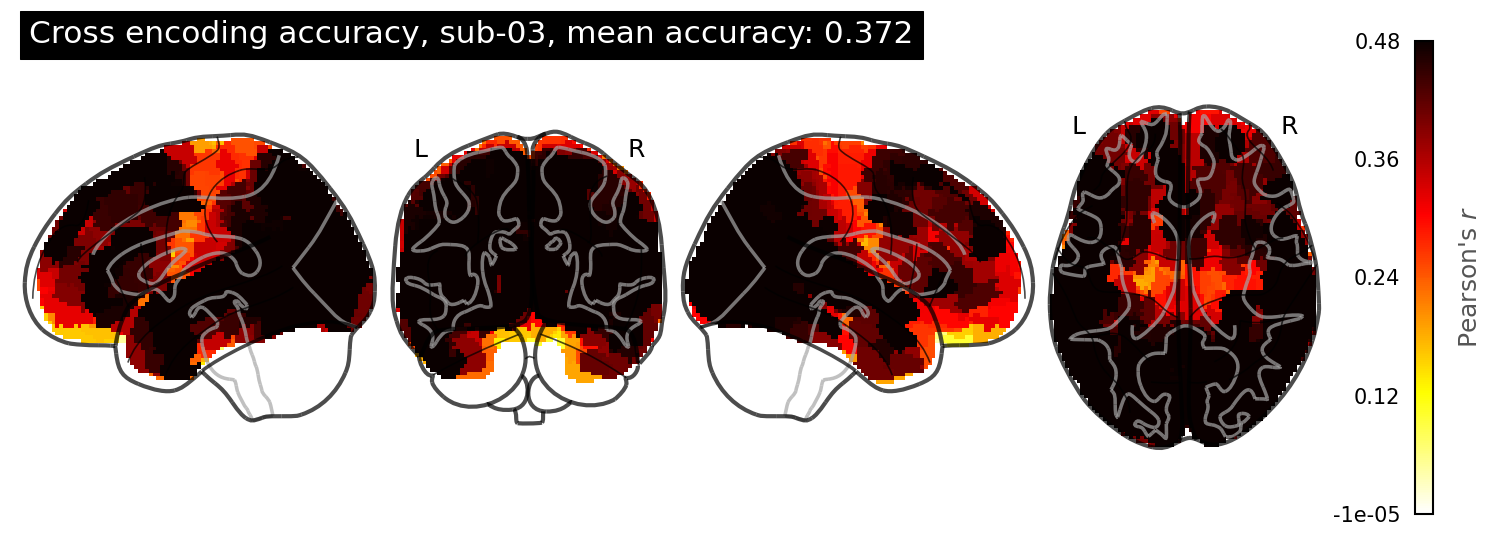

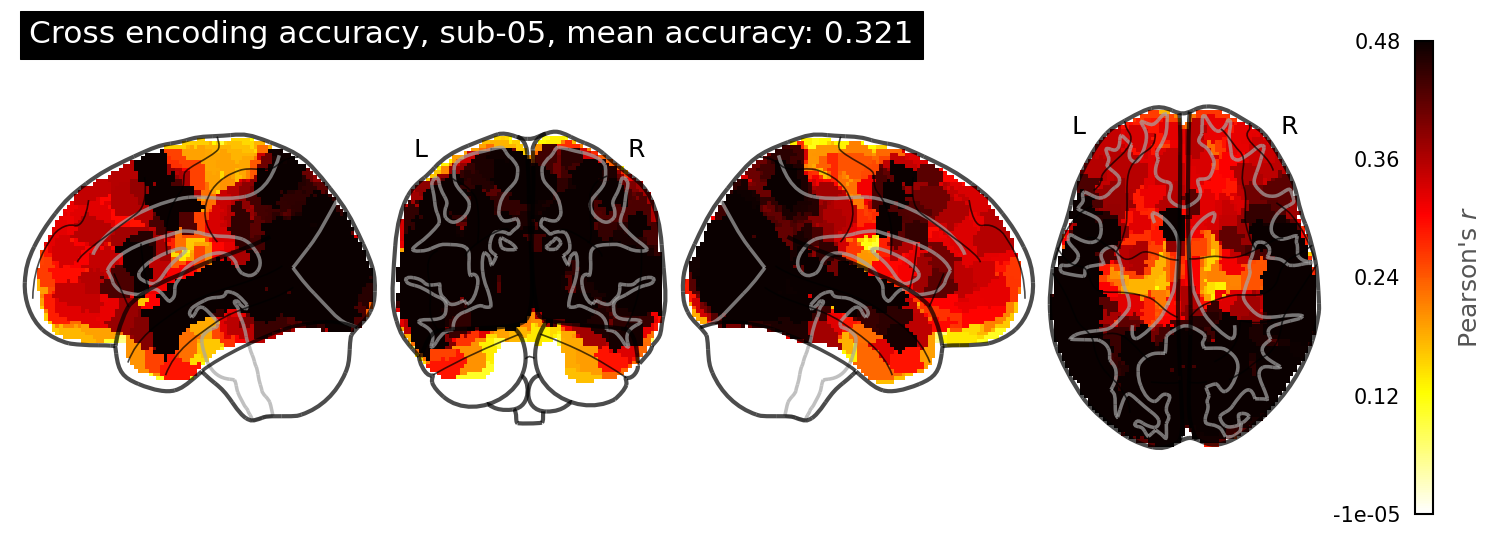

In [90]:
for sub in SUBJECTS:
    plot_encoding_accuracy(atlas_masker, metrics[f"acc_map_sub-{sub}"], sub, vmin=0.0, vmax=0.48)
    plt.savefig(OUT_DIR / f"cross_enc_acc_glass_brain_sub-{sub}.png")

### Flat map encoding accuracy

In [28]:
import nibabel as nib
from nisc.surface import load_flat
from nisc.resample import Resampler
from nisc.cifti import get_cifti_surf_data
from matplotlib import pyplot as plt

In [29]:
# Settings for flat map
PIXEL_SIZE = 2.0
RECT = (-314.0, 324.0, -138.0, 148.0)

plt.style.use("ggplot")
plt.rcParams["figure.dpi"] = 150

In [30]:
def load_resampler_parc() -> tuple[Resampler, np.ndarray]:
    parc = get_cifti_surf_data(
        nib.load(ROOT / "resources/Schaefer2018_1000Parcels_7Networks_order.dscalar.nii")
    )
    parc = parc.flatten()

    mask = parc > 0
    flat = load_flat("32k_fs_LR")
    flat = flat.extract_patch(mask=mask)

    resampler = Resampler(pixel_size=PIXEL_SIZE, rect=RECT)
    resampler.fit(flat.points)

    parc_flat = resampler.transform(parc[mask], categorical=True)

    N, P = int(resampler.mask_.sum()), int(parc.max())
    parc_one_hot = np.zeros((N, P))
    parc_indices = parc_flat[resampler.mask_].astype(np.int64) - 1
    parc_one_hot[np.arange(N), parc_indices] = 1.0
    return resampler, parc_one_hot

In [31]:
resampler, parc_one_hot = load_resampler_parc()

In [29]:
def map_to_flat(
    resampler: Resampler,
    parc_one_hot: np.ndarray,
    data: np.ndarray,
):
    assert data.ndim == 1
    H, W = resampler.mask_.shape
    flat_data = np.full((H, W), fill_value=np.nan, dtype=data.dtype)
    flat_data[resampler.mask_] = parc_one_hot @ data
    return flat_data

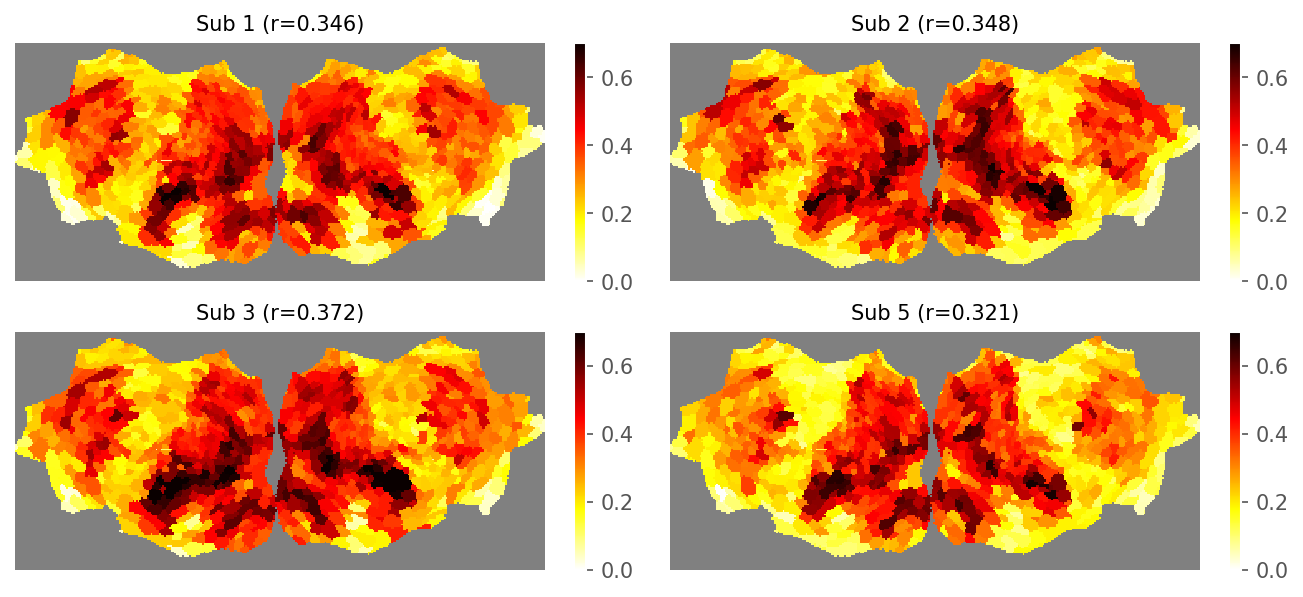

In [96]:
cmap = plt.get_cmap("hot_r")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 2
nc = 2

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii, sub in enumerate(SUBJECTS):
    plt.sca(axs[ii])

    acc = metrics[f"acc_sub-{sub}"]
    acc_flat = map_to_flat(resampler, parc_one_hot, metrics[f"acc_map_sub-{sub}"])

    plt.imshow(acc_flat, cmap=cmap, interpolation="nearest", vmin=0.0, vmax=0.7)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Sub {sub} (r={acc:.3f})", fontsize="medium")

plt.tight_layout()
plt.savefig(OUT_DIR / "cross_enc_acc_flat_map.png")

### Visualizing conv weights

Visualizing how the conv (temporal) layers look.

In [76]:
def get_conv_weights(model: CrossSubjectConvLinearEncoder):
    encoder_weight = np.stack(
        [
            model.encoders[ii].conv.weight.data.cpu().numpy().squeeze()
            for ii in range(len(SUBJECTS))
        ]
    )
    decoder_weight = np.stack(
        [
            model.decoders[ii].conv.weight.data.cpu().numpy().squeeze()
            for ii in range(len(SUBJECTS))
        ]
    )
    return encoder_weight, decoder_weight

In [78]:
enc_weight, dec_weight = get_conv_weights(model)
print(enc_weight.shape, dec_weight.shape)

(4, 1000, 11) (4, 1000, 11)


Plot the temporal conv kernels for each subject time point.

In [ ]:
cmap = plt.get_cmap("turbo")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 8 
nc = 11

vmin, vmax = enc_weight.min(), enc_weight.max()

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for ii, sub in enumerate(SUBJECTS):
    for jj in range(nc):
        plt.sca(axs[ii, jj])
        weight_flat_ij = map_to_flat(resampler, parc_one_hot, enc_weight[ii, :, jj])
        plt.imshow(weight_flat_ij, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Enc: Sub {sub} (t={jj})", fontsize="medium")
        
        plt.sca(axs[4 + ii, jj])
        weight_flat_ij = map_to_flat(resampler, parc_one_hot, dec_weight[ii, :, jj])
        plt.imshow(weight_flat_ij, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Dec: Sub {sub} (t={jj})", fontsize="medium")

plt.tight_layout()
plt.savefig(OUT_DIR / "conv_kernel_weights.png")

Absolute value of kernels just to see weights.

In [ ]:
cmap = plt.get_cmap("turbo")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 8 
nc = 11

enc_weight_abs = np.abs(enc_weight)
dec_weight_abs = np.abs(dec_weight)

vmin, vmax = 0.0, enc_weight_abs.max()

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for ii, sub in enumerate(SUBJECTS):
    for jj in range(nc):
        plt.sca(axs[ii, jj])
        weight_flat_ij = map_to_flat(resampler, parc_one_hot, enc_weight_abs[ii, :, jj])
        plt.imshow(weight_flat_ij, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Enc: Sub {sub} (t={jj})", fontsize="medium")
        
        plt.sca(axs[4 + ii, jj])
        weight_flat_ij = map_to_flat(resampler, parc_one_hot, dec_weight_abs[ii, :, jj])
        plt.imshow(weight_flat_ij, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Dec: Sub {sub} (t={jj})", fontsize="medium")

plt.tight_layout()
plt.savefig(OUT_DIR / "conv_kernel_weights_abs.png")

In [107]:
def center_scale(weight: np.ndarray):
    kernel_size = weight.shape[-1]
    pos = np.arange(kernel_size) - kernel_size // 2
    weight = np.abs(weight)
    weight = weight / weight.sum(axis=-1, keepdims=True)
    center = (pos * weight).sum(axis=-1, keepdims=True)
    scale = np.sqrt((weight * (pos - center) ** 2).sum(axis=-1))
    return center.squeeze(), scale

Center and scale maps for each subject

In [108]:
enc_center, enc_scale = center_scale(enc_weight)
dec_center, dec_scale = center_scale(dec_weight)

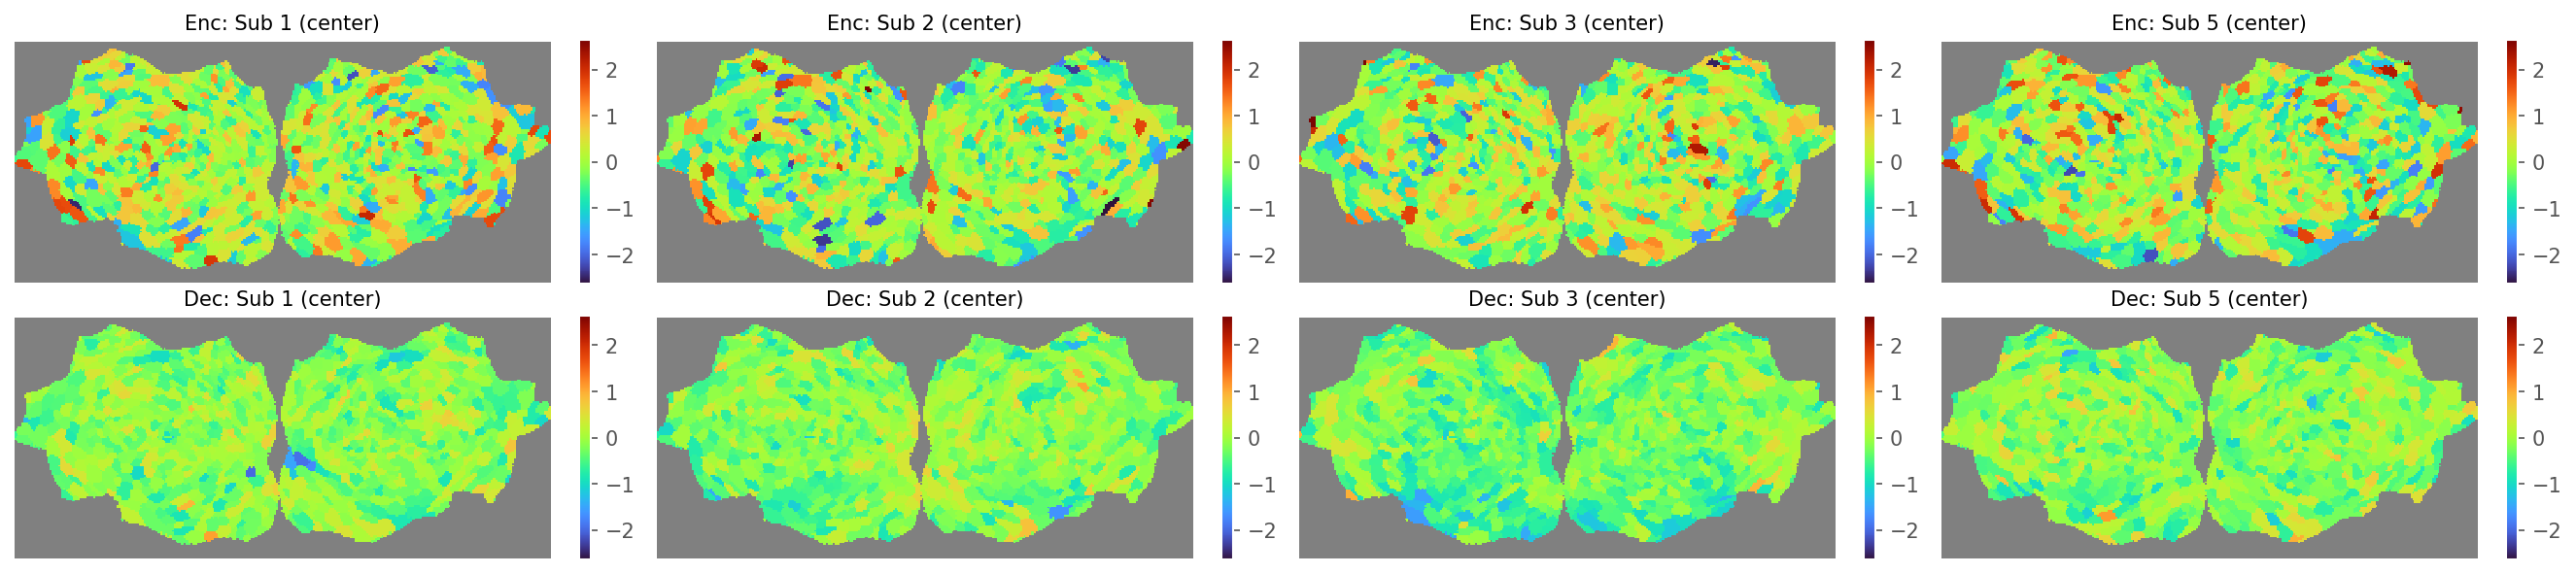

In [111]:
cmap = plt.get_cmap("turbo")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 2
nc = 4

vmax = np.max(np.abs(enc_center))
vmin = -vmax

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for jj, sub in enumerate(SUBJECTS):
    plt.sca(axs[0, jj])
    flat_img = map_to_flat(resampler, parc_one_hot, enc_center[jj])
    plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Enc: Sub {sub} (center)", fontsize="medium")
    
    plt.sca(axs[1, jj])
    flat_img = map_to_flat(resampler, parc_one_hot, dec_center[jj])
    plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Dec: Sub {sub} (center)", fontsize="medium")
    
plt.tight_layout()
plt.savefig(OUT_DIR / "conv_kernel_center.png")

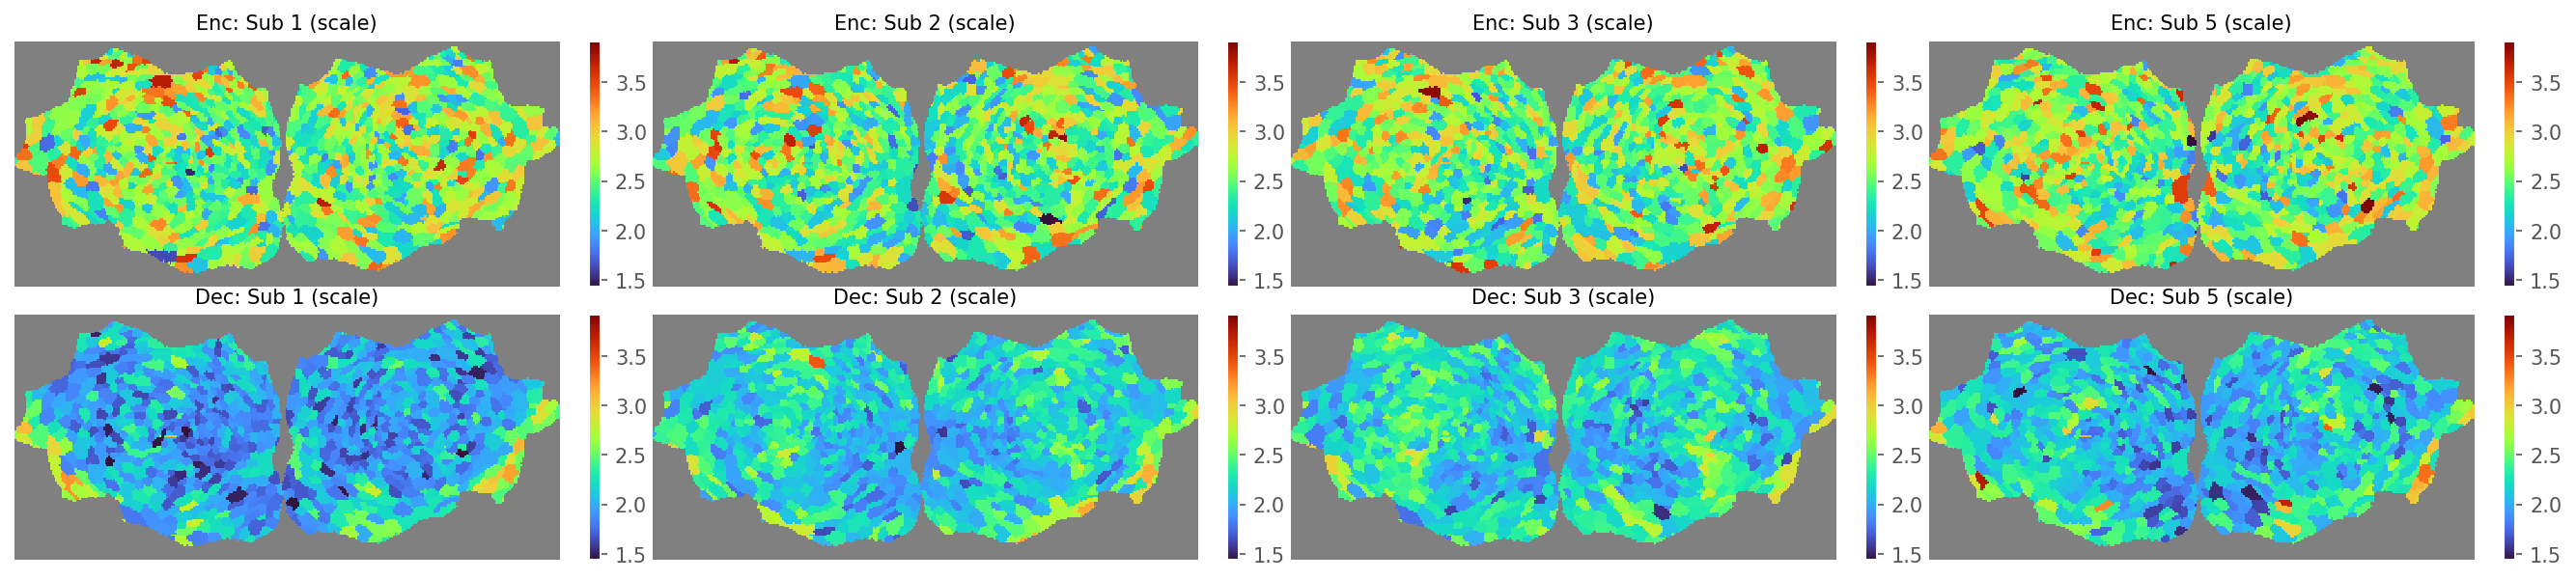

In [112]:
cmap = plt.get_cmap("turbo")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 2
nc = 4

vmin, vmax = enc_scale.min(), enc_scale.max()

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for jj, sub in enumerate(SUBJECTS):
    plt.sca(axs[0, jj])
    flat_img = map_to_flat(resampler, parc_one_hot, enc_scale[jj])
    plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Enc: Sub {sub} (scale)", fontsize="medium")
    
    plt.sca(axs[1, jj])
    flat_img = map_to_flat(resampler, parc_one_hot, dec_scale[jj])
    plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.colorbar(fraction=0.047 * (H / W))
    plt.axis("off")
    plt.title(f"Dec: Sub {sub} (scale)", fontsize="medium")
    
plt.tight_layout()
plt.savefig(OUT_DIR / "conv_kernel_scale.png")

### Visualizing FC weights

In [118]:
def get_fc_weights(model: CrossSubjectConvLinearEncoder):
    encoder_weight = np.stack(
        [
            model.encoders[ii].fc.weight.data.cpu().numpy()
            for ii in range(len(SUBJECTS))
        ]
    )
    decoder_weight = np.stack(
        [
            model.decoders[ii].fc.weight.data.cpu().numpy().swapaxes(-1, -2)
            for ii in range(len(SUBJECTS))
        ]
    )
    return encoder_weight, decoder_weight

In [119]:
enc_fc_weight, dec_fc_weight = get_fc_weights(model)
print(enc_fc_weight.shape, dec_fc_weight.shape)

(4, 256, 1000) (4, 256, 1000)


In [ ]:
cmap = plt.get_cmap("turbo")
cmap.set_bad("gray")

H, W = resampler.mask_.shape
ploth = 2.0
plotw = (W / H) * ploth
nr = 8 
nc = 6

vmax = np.max(np.abs(enc_fc_weight))
vmin = -vmax

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

for ii, sub in enumerate(SUBJECTS):
    for jj in range(nc):
        plt.sca(axs[ii, jj])
        flat_img = map_to_flat(resampler, parc_one_hot, enc_fc_weight[ii, jj])
        plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Enc fc: Sub {sub} (j={jj})", fontsize="medium")
        
        plt.sca(axs[4 + ii, jj])
        flat_img = map_to_flat(resampler, parc_one_hot, dec_fc_weight[ii, jj])
        plt.imshow(flat_img, cmap=cmap, interpolation="nearest", vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=0.047 * (H / W))
        plt.axis("off")
        plt.title(f"Dec fc: Sub {sub} (j={jj})", fontsize="medium")

plt.tight_layout()
plt.savefig(OUT_DIR / "fc_weights.png")

### Exporting reconstructed activity

In [36]:
from fractions import Fraction

import av
from PIL import Image
from tqdm import tqdm

CMAP = plt.get_cmap("turbo")
CMAP.set_bad("gray")

FPS = Fraction(268, 100)
VMAX = 1.5

In [37]:
@torch.no_grad()
def inference(
    *,
    model: torch.nn.Module,
    val_loader: DataLoader,
    device: torch.device,
):
    model.eval()

    samples = {}
    recons = {}

    for batch_idx, (task, sample) in enumerate(val_loader):
        assert len(task) == len(sample) == 1
        output = model.forward(sample.to(device))
        samples[task[0]] = sample[0].cpu().numpy()
        recons[task[0]] = output[0].cpu().numpy()

    return samples, recons

In [38]:
samples, recons = inference(model=model, val_loader=val_loader, device=device)

In [39]:
def save_frames_video(path: Path, images: list[Image.Image], fps: int | Fraction = 24):
    container = av.open(path, mode="w")
    stream = container.add_stream("h264", rate=fps)
    stream.pix_fmt = "yuv420p"
    stream.options = {"crf": "18", "preset": "veryfast"}

    for ii, img in enumerate(images):
        if ii == 0:
            stream.height = img.height
            stream.width = img.width

        frame = av.VideoFrame.from_image(img)
        for packet in stream.encode(frame):
            container.mux(packet)

    # Finalize the file
    for packet in stream.encode():
        container.mux(packet)

    container.close()

In [40]:
def image_grid(images: list[Image.Image], ncol: int):
    widths, heights = zip(*(img.size for img in images))

    width = max(widths)
    height = max(heights)
    nrow = math.ceil(len(images) / ncol)

    right, lower = 0, 0

    grid = Image.new(images[0].mode, size=(ncol * width, nrow * height))
    for ii, img in enumerate(images):
        row = ii // ncol
        col = ii % ncol
        grid.paste(img, (col * width, row * height))

        right = max(right, col * width + img.width)
        lower = max(lower, row * height + img.height)

    grid = grid.crop((0, 0, right, lower))
    return grid

In [41]:
def transform_frame(
    resampler: Resampler,
    parc_one_hot: np.ndarray,
    data: np.ndarray,
    vmax: float = 2.5,
):
    assert data.ndim == 1
    H, W = resampler.mask_.shape
    flat_data = np.full((H, W), fill_value=np.nan, dtype=data.dtype)
    flat_data[resampler.mask_] = parc_one_hot @ data

    frame = np.clip((flat_data + vmax) / (2 * vmax), 0, 1)
    frame = CMAP(frame)
    frame = (255 * frame[..., :3]).astype(np.uint8)
    frame = Image.fromarray(frame)
    return frame

In [43]:
recon_video_dir = OUT_DIR / "recon_videos"
recon_video_dir.mkdir(exist_ok=True, parents=True)

tasks = list(samples)[1:10]

for task in tqdm(tasks):
    sample = samples[task]
    recon = recons[task]
    frames = []
    for idx in range(sample.shape[1]):
        sample_maps = [
            transform_frame(resampler, parc_one_hot, sample[ii, idx], vmax=VMAX)
            for ii in range(4)
        ]
        recon_maps = [
            transform_frame(resampler, parc_one_hot, recon[ii, idx], vmax=VMAX)
            for ii in range(4)
        ]
        grid = image_grid(sample_maps + recon_maps, ncol=4)
        frames.append(grid)

    save_frames_video(recon_video_dir / f"recon_video_{task}.mp4", frames, fps=FPS)

100%|██████████| 9/9 [03:24<00:00, 22.78s/it]
